# Causal Primer


In this notebook we are going to see some techniques and approaches related to causality, ranging from **Randomized Controlled Trials (RCT)** to more complex and refined techniques, such as **Difference-in-Difference (DiD)** and **Double Machine Learning**.

The following notebook is divide into 6(?) sections, each presenting a different technique for identifying and estimating the causal effect of the treatment variable with respect to the outcome variable. 

The presented techniques are:
1. Randomized Controlled Trials (RCTs)
2. Matching and Propensity Scores (PS)
3. Instrumental Variables (IV)
4. Difference-in-Difference (DiD)
5. Regression Discontinuity Design (RDD)
6. Meta-Learners (S, T, X)
7. Double Machine Learning

#### Setup

In [84]:
import os
import sys
import glob
import wget


import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm

import graphviz as gv
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import causalinference as ci
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb


In [85]:
# plt.style.use("dark_background")
sns.set_theme(style="darkgrid", palette="deep")

In [86]:
bar = None
def progress_bar(current, total, width=80):
    global bar
    if bar is None:
        bar = tqdm.tqdm(total=total, unit='B', unit_scale=True, leave=False, desc="Downloading file") 
    
    bar.update(current - bar.n)
    if current == total:
        bar.close()
        bar = None

In [87]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

## Randomized Controlled Trials

Randomized Controlled Trials (RCT), also known as Random Experiments, is the first and easiest tool to apply in order to be able to estimate the Average Treatment Estimation (ATE). 

Randomised experiments randomly assign individuals in a population to a treatment or to a control group. The proportion that receives the treatment doesn’t have to be 50%. You could have an experiment where only 10% of your samples get the treatment. Randomisation annihilates bias by making the potential outcomes independent of the treatment, i.e.:
$$
(Y_0, Y_1) \; {\perp \!\!\! \perp} \; T
$$
In simpler terms, it means that treatment and control groups are comparable. Or that knowing the treatment assignment doesn’t give us any information on how the outcome was previous to the treatment. Consequently, it means that the treatment is the only thing generating a difference between the outcome in the treated and in the control group.

Please note, we **do not** want $Y  \; {\perp \!\!\! \perp} \;  T$, otherwise the treatment would not cause the outcome.

### HDPI Dataset


In 1985 began the [Infant Health and Development Progam (IHDP)](https://doi.org/10.3886/ICPSR09795.v2), a randomized experiment targeting low-birth, premature infants and providing the treatment group with both intensive high-quality child care and home visits from a trained provider. The control group was provided only with child care. The aim of the program was to raise cognitive test scores (among other scores) of the treated children.

The study collected data on many pretreatment variables. The measurements used are on the child :
- birth weight;
- head circumference;
- weeks born preterm;
- birth order;
- first born;
- neonatal health index;
- sex;
- twin status;

as well as behaviors engaged in during the pregnancy:
- smoked cigarettes;
- drank alcohol;
- took drugs;

and measurements on the mother at the time she gave birth:

- age;
- marital status;
- educational attainment (did not graduate from high school, graduated from high school, attended some college but did not graduate, graduated from college);
- whether she worked during pregnancy;
- whether she received prenatal care;
- site (8 total) in which the family resided at the start of the intervention.

There are 6 continuous covariates and 19 binary covariates.

In [88]:
!mkdir -p datasets/ihdp

BASE_URL = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv"
DATASET_DIR = "./datasets/ihdp"

# Download the IHDP dataset
for i in tqdm.tqdm(range(1, 11), desc="Downloading IHDP dataset"):
  filename = f"ihdp_npci_{i}.csv"
  path = os.path.join(DATASET_DIR, filename)
  if not os.path.exists(path):
    wget.download(f"{BASE_URL}/{filename}", path, bar=progress_bar)

In [89]:
# Load dataset
chunks = sorted(glob.glob(os.path.join(DATASET_DIR, "*.csv")), key=os.path.getmtime)

df = pd.concat((pd.read_csv(f, header=None) for f in chunks), ignore_index=True)
df.columns = ["home_visits", "cognitive_score", "cognitive_score_cf", "mu0", "mu1", *(f"x{i}" for i in range(1,26))]
df = df.astype({"home_visits":'int'}).drop(columns=['mu0', 'mu1'])

df


,home_visits,cognitive_score,cognitive_score_cf,x1,x2,x3,x4,x5,x6,x7,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7465,0,23.593435,24.884255,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,1.792063,0,...,1,0,1,0,0,0,0,0,0,0
7466,1,25.709389,22.490685,0.727295,-0.202946,-0.733261,-0.879606,0.808706,1.129600,0,...,1,1,1,0,0,0,0,0,0,0
7467,0,16.604718,24.394490,1.181234,0.196818,-1.477987,0.161703,0.746189,0.467138,0,...,1,1,1,0,0,0,0,0,0,0
7468,0,28.624417,25.721615,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,0.467138,1,...,1,1,1,0,0,0,0,0,0,0


### ATE Estimation

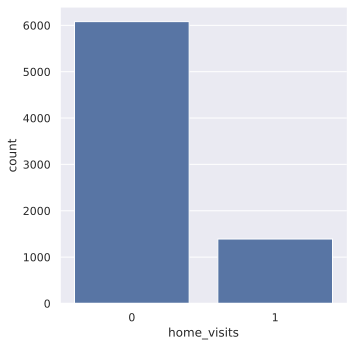

In [90]:
sns.catplot(df, x="home_visits", kind="count")
plt.show()

In [91]:
df.groupby("home_visits").mean()

,cognitive_score,cognitive_score_cf,x1,x2,x3,x4,x5,x6,x7,x8,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
home_visits,,,,,,,,,,,,,,,,,,,,,
0,9.152685,14.081442,-0.048028,-0.041786,0.010240,0.050378,0.032485,-0.048504,0.513158,0.095395,...,0.965461,0.572368,0.957237,0.131579,0.151316,0.152961,0.092105,0.087171,0.144737,0.131579
1,14.094862,10.138704,0.210078,0.182776,-0.044791,-0.220360,-0.142095,0.212161,0.517986,0.086331,...,0.935252,0.690647,0.992806,0.151079,0.064748,0.172662,0.035971,0.014388,0.057554,0.273381


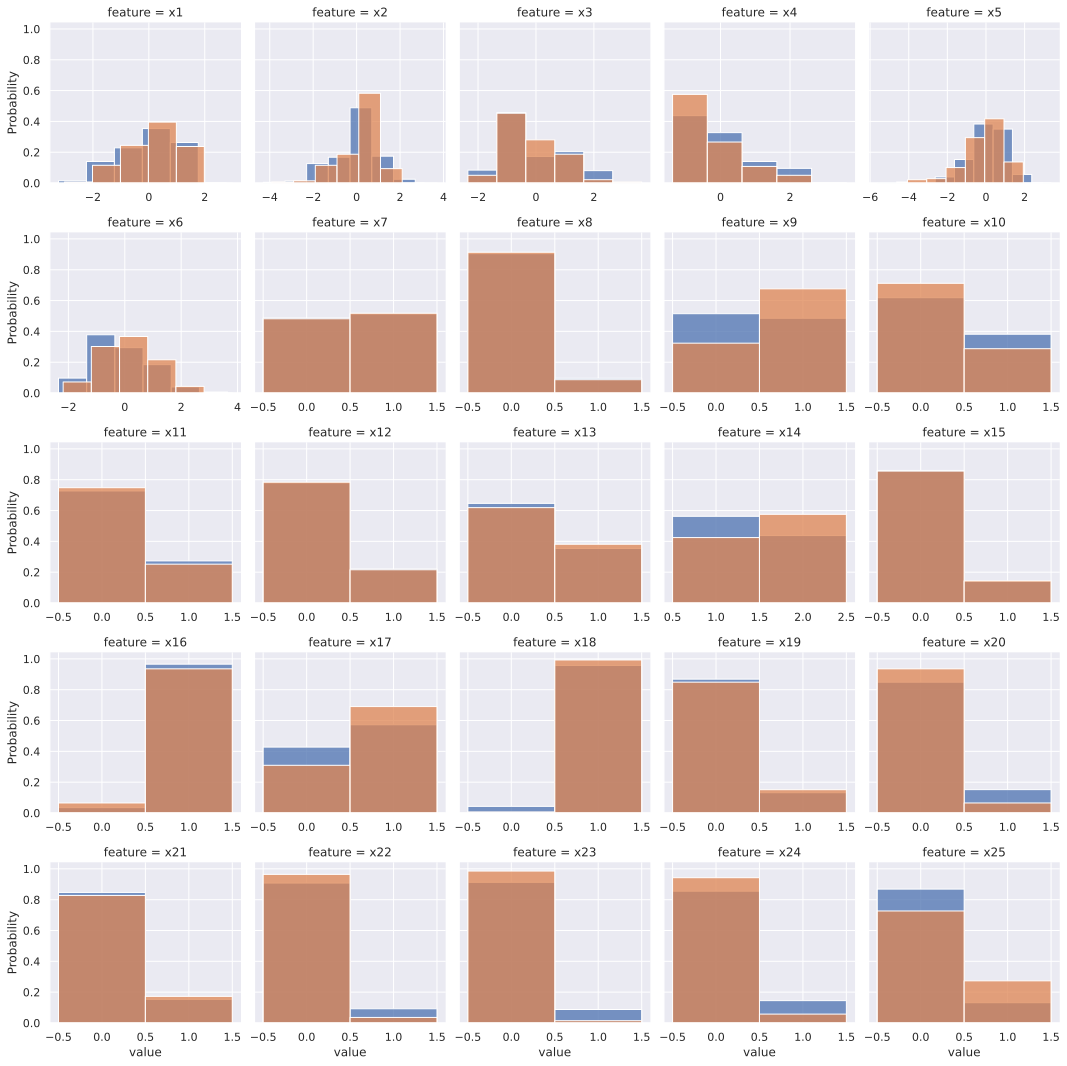

In [92]:
_df = df.drop(columns=["cognitive_score", "cognitive_score_cf"]).melt(var_name="feature", value_name="value", id_vars=["home_visits"])
g = sns.FacetGrid(_df, col="feature", col_wrap=5, sharex=False, hue='home_visits')
g.map(sns.histplot, "value", stat="probability", bins=10, discrete=True)

plt.show()

The two groups look, for the most part, similar in distribution. When there exist differences, we can attribute them to the small number of examples that were collected. We can therefore consider the collected data as experimental data coming from an RCT.

In this case, we can simply compute the **Average Treatment Effect (ATE)** and the **Average Treatment Effect of the Treated (ATT)** as:
$$
ATE = ATT = \mathbb{E}[ Y \mid T = 1 ] - \mathbb{E}[ Y \mid T = 0 ]
$$

because the bias $\mathbb{E}[ Y_0 \mid T = 1 ] - \mathbb{E}[ Y_0 \mid T = 0 ]$  evaluates to $0$ due to the two groups being chosen at random (remember that the bias is given by how the treated and control group differ **before** the treatment, in case neither of them has received the treatment).

In [93]:
att = df.query("home_visits == 1")["cognitive_score"].mean() - df.query("home_visits == 0")["cognitive_score"].mean()
print(f"ATE: {att:.3f}")

ATE: 4.942


## Mathching & Propensity Score

RCTs, altough they lead to simple calculations, are not always feasible or ethical to conduct (e.g., a study on the effect of smoking means imposing the use of cigarettes to teenagers or pregnant women). Moreover, there is no guarantee the members of a group will comply with the instructions given to that group (e.g., non-compliers in the control group will smoke even if they are told not to). 

We move now onto studying techniques that can identify causal effects with observational studies, in which we may have no control over the group assignment mechanism, and where the treatment is not assigned at random but following some (unknown) mechanism. 

The problem is that there are confounder variables rendering treated and untreated not comparable before treatment. What one could do is **mathching each treated unit with a similar untreated unit**, i.e., finding a *twin* for each treated unit. With this procedure, we make treated and control group once again comparable.

### LaLonde Dataset

Economists have long-hypothesized that training programs could improve the labor market prospects of participants. In an attempt to test (or demonstrate) this, the National Supported Work (NSW) Demonstration was initiated using combined private and federal funding. This program was implemented between 1975 and 1979 in 15 locations across the US. The program provided 6-18 month training for individuals who had faced economic and social problems (such as women receiving Aid to Families with Dependent Children, former drug addicts, ex-convicts, and former juvenile delinquents, etc.).

Participants were randomly assigned into experimental group (Support Work Programs) and control groups. However, due to the long duration of the study, participants joining the program at the beginning had different characteristics than people joining later.
Therefore, this covariate shift should be adjusted for in order to estimate the true causal effect of the job-program on future employment.

Furthermore, we add some observational data that was obtained from the Population Survey of Income Dynamics and the Current Population Survey. These did not receive any training and are considered controls.

This dataset had become a common benchmark for causal analysis over the years. Original analysis of the study was done by Robert LaLonde and published in his 1986 [Evaluating the Econometric Evaluations of Training Programs with Experimental Data](http://people.hbs.edu/nashraf/LaLonde_1986.pdf) paper.

In [94]:
!mkdir -p datasets/lalonde


BASE_URL = "http://www.nber.org/~rdehejia/data"
FILE_NAMES = [
 "nswre74_treated.txt",
  "nswre74_control.txt",
  "psid_controls.txt",
  "psid2_controls.txt",
  "psid3_controls.txt",
  "cps_controls.txt",
  "cps2_controls.txt",
  "cps3_controls.txt"
]
DATASET_DIR = "./datasets/lalonde"

# Download the (extendend) LaLonde dataset
for f in tqdm.tqdm(FILE_NAMES, desc="Downloading the LaLonde dataset"):
  path = os.path.join(DATASET_DIR, f)
  
  if not os.path.exists(path):
    wget.download(f"{BASE_URL}/{f}", path, bar=progress_bar)

files = glob.glob(os.path.join(DATASET_DIR, "*.txt"))
df = pd.concat([pd.read_csv(f, sep=r'\s+', header=None,) for f in files], ignore_index=True)



In [95]:
columns = [
  "training",   # Treatment assignment indicator
  "age",        # Age of participant
  "education",  # Years of education
  "black",      # Indicate whether individual is black
  "hispanic",   # Indicate whether individual is hispanic
  "married",    # Indicate whether individual is married
  "no_degree",  # Indicate if individual has no high-school diploma
  "re74",       # Real earnings in 1974, prior to study participation
  "re75",       # Real earnings in 1975, prior to study participation
  "re78"        # Real earnings in 1978, after study end
  ]       

df.columns = columns
df = df.astype({"training":'int', "black":'int', "hispanic":'int', "married":'int', "no_degree":'int'})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df

,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
0,0,19.0,11.0,0,0,0,1,1692.8070,4823.129,12578.410
1,0,18.0,12.0,1,0,0,0,186.1303,0.000,3293.853
2,0,27.0,12.0,0,0,1,0,0.0000,0.000,0.000
3,0,38.0,16.0,0,0,1,0,25860.3600,25243.550,25564.670
4,0,29.0,12.0,0,0,0,0,43103.8700,37596.774,50242.704
...,...,...,...,...,...,...,...,...,...,...
22101,0,26.0,13.0,0,1,1,0,10740.7000,10928.130,11350.420
22102,0,53.0,7.0,0,0,1,1,19257.6300,10331.950,8739.275
22103,0,18.0,11.0,0,0,0,1,497.6538,0.000,16860.860
22104,0,23.0,16.0,1,0,0,0,9012.6273,16490.661,19210.445


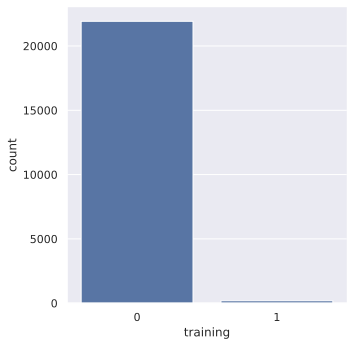

The dataset contains 22106 people, out of which 185 received training


In [96]:
sns.catplot(df, x="training", kind="count")
plt.show()

print(f'The dataset contains {df.shape[0]} people, out of which {df["training"].sum():.0f} received training')

In [97]:
att = df.query("training == 1")["re78"].mean() - df.query("training == 0")["re78"].mean()
print(f"ATE: {att:.3f}")

df.groupby('training')['re78'].agg(['median','mean'])



ATE: -8366.316


,median,mean
training,,
0,15319.590,14715.459545
1,4232.309,6349.143530


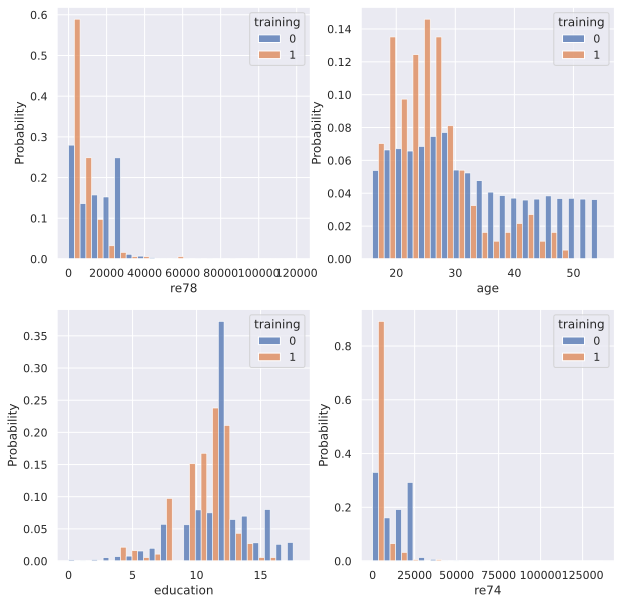

In [98]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, sharey=False)
sns.histplot(df, x="re78", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[0, 0])
sns.histplot(df, x="age", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[0, 1])
sns.histplot(df, x="education", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[1, 0])
sns.histplot(df, x="re74", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[1, 1])
plt.show()

### Simple 1:1 Matching

In [99]:
from sklearn.preprocessing import StandardScaler

X = ["age", "education", "black", "hispanic", "married", "no_degree", "re74", "re75"]
y = ["re78"]


scaler = StandardScaler()
scaler.fit(df[X + y])
df[X + y] = scaler.transform(df[X + y])

In [100]:
# Find nearest neighbors
from sklearn.neighbors import NearestNeighbors

treated = df.query("training == 1")
control = df.query("training == 0")

match = NearestNeighbors(n_neighbors=3).fit(control[X])

matched_control = control.iloc[match.kneighbors(treated[X], return_distance=False).flatten()]
matched_control

,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
21517,0,-0.684854,-0.296666,2.691734,-0.275929,0.674191,1.416905,-1.299831,-1.266753,-1.344943
11349,0,-0.952421,-0.296666,2.691734,-0.275929,0.674191,1.416905,-1.299831,-1.266753,-1.192626
6336,0,-0.595665,-0.296666,2.691734,-0.275929,0.674191,1.416905,-1.299831,-0.858751,-1.349065
9262,0,-1.219988,-0.296666,2.691734,-0.275929,-1.483259,1.416905,-1.299831,-1.266753,-1.349065
5808,0,-1.219988,-0.296666,2.691734,-0.275929,-1.483259,1.416905,-1.299831,-1.266753,0.169499
...,...,...,...,...,...,...,...,...,...,...
5749,0,0.028658,0.049536,-0.371508,-0.275929,0.674191,-0.705764,-1.299831,-1.266753,1.005825
5185,0,0.028658,0.049536,-0.371508,-0.275929,0.674191,-0.705764,-1.299831,-1.266753,-1.349065
13217,0,0.474603,-3.066281,2.691734,-0.275929,-1.483259,1.416905,-0.417070,-0.504832,-1.349065
20976,0,0.296225,-2.027675,2.691734,-0.275929,-1.483259,1.416905,-0.582177,-0.540615,-0.940703


In [101]:
matched_df = pd.concat([treated, matched_control], ignore_index=True)
matched_df[X + y] = scaler.inverse_transform(matched_df[X + y])
df[X + y] = scaler.inverse_transform(df[X + y])

matched_df

,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
0,1,24.0,11.0,1.0,0.0,1.0,1.0,824.3886,1666.1130,4.032708e+03
1,1,20.0,11.0,1.0,0.0,0.0,1.0,0.0000,0.0000,3.972540e+03
2,1,25.0,12.0,1.0,0.0,0.0,0.0,0.0000,0.0000,3.191753e+03
3,1,20.0,11.0,1.0,0.0,0.0,1.0,16318.6200,1484.9940,6.943342e+03
4,1,26.0,11.0,0.0,0.0,0.0,1.0,0.0000,2226.2660,1.338586e+04
...,...,...,...,...,...,...,...,...,...,...
735,0,33.0,12.0,0.0,0.0,1.0,0.0,0.0000,0.0000,2.556467e+04
736,0,33.0,12.0,0.0,0.0,1.0,0.0,0.0000,0.0000,-1.818989e-12
737,0,38.0,3.0,1.0,0.0,0.0,1.0,9218.3500,7814.7580,-1.818989e-12
738,0,36.0,6.0,1.0,0.0,0.0,1.0,7494.1955,7447.7419,4.433180e+03


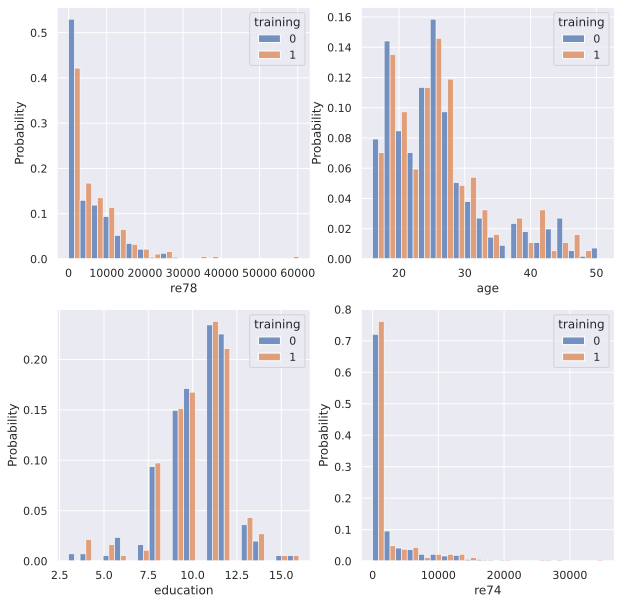

In [102]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, sharey=False)
sns.histplot(matched_df, x="re78", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[0, 0])
sns.histplot(matched_df, x="age", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[0, 1])
sns.histplot(matched_df, x="education", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[1, 0])
sns.histplot(matched_df, x="re74", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[1, 1])
plt.show()

In [103]:
att = matched_df.query("training == 1")["re78"].mean() - matched_df.query("training == 0")["re78"].mean()
print(f"ATE: {att:.3f}")

matched_df.groupby('training')['re78'].agg(['median','mean'])

ATE: 1474.796


,median,mean
training,,
0,2500.313,4874.347951
1,4232.309,6349.143530


In [104]:
cm = ci.CausalModel(
    Y=matched_df["re78"].values, 
    D=matched_df["training"].values, 
    X=matched_df[X].values
)

cm.est_via_matching(matches=5, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1359.093    730.129      1.861      0.063    -71.960   2790.147
           ATC   1215.838    750.985      1.619      0.105   -256.092   2687.768
           ATT   1788.860    715.835      2.499      0.012    385.823   3191.897



/home/federico/envs/causal/lib/python3.11/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


### Propensity Score

A more refined approach is that of **Propensity Score**. It stems from the idea that, based on the covariate features, one unit is more or less inclined to be treated, independently from the fact that the treatment assignment was actually randomized. For example, the possibility to participate to the training course could have been randomized, but only those who actually wanted to partecipate (due to their personal ambitions) did receive the treatment.

Propensity scores rationalize this intuition by estimating a score $0 <= e(x) <= 1$ that represent $P(T \mid X)$. In this way, we can match only on the propensity score and tamper some of the brawbacks of using Nearest-Neighbors Algorithms. 

If we were to represent this intuition as a Bayesian Network, we would draw something as follows:

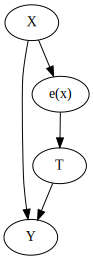

In [105]:
g = gv.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

If I know what $e(x)$ is, $X$ alone tells me nothing more that can help me learn what $T$ would be

In [106]:
df = pd.get_dummies(df, columns=["education"], drop_first=True)
# df = df.join((df[["re74", "re75"]] == 0).astype(int), rsuffix="_is_zero")

X = list(df.columns.drop(["training", "re78"]).values)

scaler = StandardScaler()
scaler.fit(df[X + y])   
df[X + y] = scaler.transform(df[X + y])

In [107]:
from sklearn.linear_model import LogisticRegression

ps_est = LogisticRegression(max_iter=1000, C=1e6, class_weight="balanced").fit(df[X], df["training"])

df["propensity_score"] = ps_est.predict_proba(df[X])[:, 1]
df

,training,age,black,hispanic,married,no_degree,re74,re75,re78,education_1.0,...,education_10.0,education_11.0,education_12.0,education_13.0,education_14.0,education_15.0,education_16.0,education_17.0,education_18.0,propensity_score
0,0,-1.219988,-0.371508,-0.275929,-1.483259,1.416905,-1.137726,-0.796509,-0.190405,-0.030836,...,-0.295293,3.477926,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,3.306002e-01
1,0,-1.309177,2.691734,-0.275929,-1.483259,-0.705764,-1.282007,-1.266753,-1.045652,-0.030836,...,-0.295293,-0.287528,1.301366,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,9.637858e-01
2,0,-0.506476,-0.371508,-0.275929,0.674191,-0.705764,-1.299831,-1.266753,-1.349065,-0.030836,...,-0.295293,-0.287528,1.301366,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,1.971814e-01
3,0,0.474603,-0.371508,-0.275929,0.674191,-0.705764,1.176589,1.194434,1.005825,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,3.400033,-0.163127,-0.171554,1.702107e-04
4,0,-0.328098,-0.371508,-0.275929,-1.483259,-0.705764,2.827850,2.398844,3.279043,-0.030836,...,-0.295293,-0.287528,1.301366,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,2.775729e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22101,0,-0.595665,-0.371508,3.624123,0.674191,-0.705764,-0.271288,-0.201286,-0.303521,-0.030836,...,-0.295293,-0.287528,-0.768423,3.809591,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,1.176572e-01
22102,0,1.812437,-0.371508,-0.275929,0.674191,1.416905,0.544304,-0.259412,-0.544047,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,1.473532e-02
22103,0,-1.309177,-0.371508,-0.275929,-1.483259,1.416905,-1.252175,-1.266753,0.204073,-0.030836,...,-0.295293,3.477926,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,5.227154e-01
22104,0,-0.863232,2.691734,-0.275929,-1.483259,-0.705764,-0.436771,0.341048,0.420505,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,3.400033,-0.163127,-0.171554,1.385471e-01


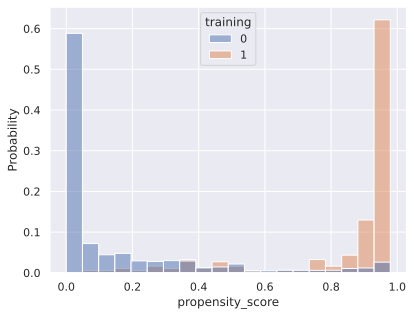

In [108]:
sns.histplot(df, x='propensity_score', hue='training', kde=False, bins=20, stat='probability', common_norm=False)
plt.show()

In [109]:
# Find nearest neighbors
from sklearn.neighbors import NearestNeighbors

treated = df.query("training == 1")
control = df.query("training == 0")

match = NearestNeighbors(n_neighbors=3).fit(control[['propensity_score']])

matched_control = control.iloc[match.kneighbors(treated[['propensity_score']], return_distance=False).flatten()]
matched_control

,training,age,black,hispanic,married,no_degree,re74,re75,re78,education_1.0,...,education_10.0,education_11.0,education_12.0,education_13.0,education_14.0,education_15.0,education_16.0,education_17.0,education_18.0,propensity_score
9648,0,-0.684854,2.691734,-0.275929,-1.483259,1.416905,0.156697,-0.967169,-1.322844,-0.030836,...,-0.295293,3.477926,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.930051
6493,0,-0.774043,2.691734,-0.275929,-1.483259,1.416905,-0.736966,-0.743096,-0.123978,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.929128
13354,0,-0.774043,2.691734,-0.275929,-1.483259,1.416905,-0.736966,-0.743096,-0.123978,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.929128
20297,0,-1.130799,2.691734,-0.275929,-1.483259,1.416905,-1.299831,-1.266753,-1.013338,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.977986
2412,0,-1.130799,2.691734,-0.275929,-1.483259,1.416905,-1.299831,-1.266753,-1.349065,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.977986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185,0,0.028658,-0.371508,-0.275929,0.674191,-0.705764,-1.299831,-1.266753,-1.349065,-0.030836,...,-0.295293,-0.287528,1.301366,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.186184
13841,0,0.028658,-0.371508,-0.275929,0.674191,-0.705764,-1.299831,-1.266753,-1.349065,-0.030836,...,-0.295293,-0.287528,1.301366,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.186184
3663,0,-1.487554,-0.371508,3.624123,-1.483259,1.416905,-1.299831,-1.266753,-0.221305,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.873280
6063,0,-1.487554,-0.371508,3.624123,-1.483259,1.416905,-1.299831,-1.266753,-0.221305,-0.030836,...,-0.295293,-0.287528,-0.768423,-0.262495,-0.273357,-0.170152,-0.294115,-0.163127,-0.171554,0.873280


In [110]:
matched_df = pd.concat([treated, matched_control], ignore_index=True)
matched_df[X + y] = scaler.inverse_transform(matched_df[X + y])
df[X + y] = scaler.inverse_transform(df[X + y])

matched_df

,training,age,black,hispanic,married,no_degree,re74,re75,re78,education_1.0,...,education_10.0,education_11.0,education_12.0,education_13.0,education_14.0,education_15.0,education_16.0,education_17.0,education_18.0,propensity_score
0,1,24.0,1.0,0.0,1.0,1.0,824.3886,1666.113,4.032708e+03,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.929743
1,1,20.0,1.0,0.0,0.0,1.0,0.0000,0.000,3.972540e+03,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.978083
2,1,25.0,1.0,0.0,0.0,0.0,0.0000,0.000,3.191753e+03,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.961096
3,1,20.0,1.0,0.0,0.0,1.0,16318.6200,1484.994,6.943342e+03,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.944650
4,1,26.0,0.0,0.0,0.0,1.0,0.0000,2226.266,1.338586e+04,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.421033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0,33.0,0.0,0.0,1.0,0.0,0.0000,0.000,-1.818989e-12,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.186184
736,0,33.0,0.0,0.0,1.0,0.0,0.0000,0.000,-1.818989e-12,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.186184
737,0,16.0,0.0,1.0,0.0,1.0,0.0000,0.000,1.224296e+04,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.873280
738,0,16.0,0.0,1.0,0.0,1.0,0.0000,0.000,1.224296e+04,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,3.469447e-18,0.873280


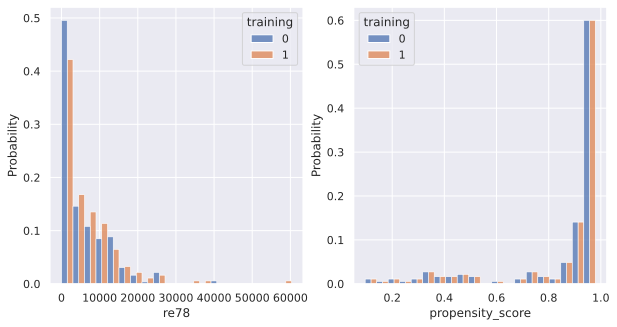

In [111]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1, sharey=False)
sns.histplot(matched_df, x="re78", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[0])
sns.histplot(matched_df, x="propensity_score", hue="training", bins=20, stat="probability", common_norm=False, multiple="dodge", ax=ax[1])
plt.show()

In [112]:
att = matched_df.query("training == 1")["re78"].mean() - matched_df.query("training == 0")["re78"].mean()
print(f"ATT: {att:.3f}")

matched_df.groupby('training')['re78'].agg(['median','mean'])

ATT: 889.919


,median,mean
training,,
0,3057.416,5459.224844
1,4232.309,6349.143530


In [113]:
cm = ci.CausalModel(
    Y=df['re78'].values, 
    D=df['training'].values, 
    X=df[['propensity_score']].values)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)

/home/federico/envs/causal/lib/python3.11/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE -11981.283   6837.972     -1.752      0.080 -25383.708   1421.143
           ATC -12085.051   6894.962     -1.753      0.080 -25599.177   1429.075
           ATT    314.444   1293.326      0.243      0.808  -2220.475   2849.363



## Regression & Instrumental Variables

One of the most important tools in Causal inference is **Linear Regression**. As simple it is, linear regression is fundamental but also the easiest to understand. 

We can view ATE as a linear regression as follows:
$$
Y_i = \beta_0 + \kappa T_i + u_i
$$

This leads to: $ \mathbb{E}\lbrack Y \mid T = 0 \rbrack = \beta_0 $ and $ \mathbb{E}\lbrack Y \mid T = 1 \rbrack = \beta_0 + \kappa $, therefore $\kappa$ is the ATE.


In [119]:
files = glob.glob(os.path.join(DATASET_DIR, "*.csv"))
df = pd.concat([pd.read_csv(f, index_col=0) for f in files], ignore_index=True)

In [120]:
columns = [
  "training",   # Treatment assignment indicator
  "age",        # Age of participant
  "education",  # Years of education
  "black",      # Indicate whether individual is black
  "hispanic",   # Indicate whether individual is hispanic
  "married",    # Indicate whether individual is married
  "no_degree",  # Indicate if individual has no high-school diploma
  "re74",       # Real earnings in 1974, prior to study participation
  "re75",       # Real earnings in 1975, prior to study participation
  "re78"        # Real earnings in 1978, after study end
  ]       

df.columns = columns
df = df.astype({"training":'int', "black":'int', "hispanic":'int', "married":'int', "no_degree":'int'})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df

,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
0,0,30,7,0,0,1,1,574.0652,2010.5320,366.4762
1,0,18,8,0,0,0,1,5023.5600,1391.0810,6756.1660
2,1,29,10,1,0,0,1,0.0000,4398.9500,0.0000
3,0,18,11,0,0,0,1,0.0000,0.0000,10150.5000
4,1,26,11,1,0,1,1,0.0000,1392.8530,1460.3600
...,...,...,...,...,...,...,...,...,...,...
609,1,46,13,1,0,0,0,0.0000,0.0000,647.2046
610,1,27,13,1,0,0,0,0.0000,0.0000,34099.2800
611,0,19,10,0,0,0,1,5777.8780,4672.7420,135.9508
612,0,16,9,0,0,0,1,0.0000,485.1774,4112.5130


In [121]:
result = smf.ols('re78 ~ training', data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6984.1697,360.710,19.362,0.000,6275.791,7692.549
training,-635.0262,657.137,-0.966,0.334,-1925.544,655.492


This results is the same as before, what we already know is that the collected data are not randomized, there are **confounder** variables that lead to differences in the control and treated groups. 

What we can do is to control also for the confounding variables, which is intuitively as fixing the value of the confounder, rendering the two groups similar again. 

In [123]:
result = smf.ols('re78 ~ training + re74 + re75 + age + education', data=df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,556.8003,1521.369,0.366,0.715,-2430.976,3544.577
training,688.3288,632.447,1.088,0.277,-553.717,1930.374
re74,0.3111,0.057,5.453,0.000,0.199,0.423
re75,0.2471,0.103,2.407,0.016,0.046,0.449
age,15.9361,30.729,0.519,0.604,-44.413,76.285
education,353.9567,110.197,3.212,0.001,137.544,570.369


First thing first, we should always include, confounding variables (the ones which causes both the treatment $T$ and outcome $Y$) in order to remove some of the bias.

We are however faced with the problem of choosing which features to include in order to remove all the bias (or, at best, the major part of it) and have statistically significant results. Causal graphs come to our aid.

We must always include:
- confounders of treatment and outcome. They reduce confounding variables
- predictors of the outcome, even when not confounders. They reduce the variance of the estimates

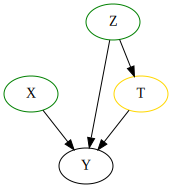

In [130]:
g = gv.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.edge("Z", "T"), g.edge("Z", "Y")
g.node("T", color="gold")
g.node("Z", color="green")
g.node("X", color="green")

g

We should not add:
- controls that are just good predictors of the treatment. They increase the variance of the estimates
- mediators between treatment and outcome and common effects. They introduce selection bias

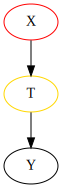

In [131]:
g = gv.Digraph()
g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")
g.node("X", color="red")
g

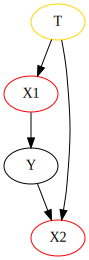

In [134]:
g = gv.Digraph()

g.edge("T", "X1"), g.node("T", color="gold"), g.edge("X1", "Y"), g.node("X1", color="red")
g.edge("T", "X2"), g.edge("Y", "X2"), g.node("X2", color="red")

g

### Instrumental Variables

There is still a problem: what if a confounder variable is not observable or hardly measurable?

We can use **Instrumental variables**, i.e., variables that cause the treatment and are correlated with the outcome through the treatment.

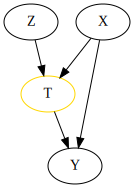

In [135]:
g = gv.Digraph()
g.edge("T", "Y"), g.edge("X", "Y"), g.edge("X", "T")
g.edge("Z", "T"), g.edge
g.node("T", color="gold")

g

What we would like to have:
$$
Y_i = \beta_0 + \kappa T_i + \beta W_i + u_i.
$$

Since we do not have data on $W$ (the confounders), all we can run:
$$
Y_i = \beta_0 + \kappa T_i + v_i \\

with \;\; v_i = \beta W_i + u_i
$$

$Cov(T, v) \neq 0$ but $Cov(Z, v) = 0$. By expanding $Cov(Z,Y)$ we obtain the *IV Formula*:
$$
\kappa = \frac{Cov(Y_i,Z_i)/V(Z_i)}{Cov(T_i,Z_i)/V(Z_i)} = \frac{Reduced\;Form}{1st\;Stage}
$$

We can compute the ATE using the *IV Formula*. The numerator is the result from the regression of $Y$ on $Z$, the denonimator is the regression of $T$ on $Z$.

We are estimating the impact of $Z$ on $Y$ and then scale it by the effect of $Z$ on $T$, since both of these are easier to estimate (no confounding)

In [ ]:
# TODO: I'm missing an example here.



## Diff-in-Diff

When dealing with temporal phenomena and interventions, one would like to understand whether possible fluctuations in the outcome are due to the intervention or a general trend.

In this setting we have data pre- and post- intervention temporal data. The idea is to collect also control data from another setting, similar to the first one where the intervention has not been performed.

The main idea behing **Difference-in-Difference** is to use the control sample to estimate the general trend, subtract it from the data related to the intervention setting and then estimate the impact of the intervention. 

We have a combination of when the intervention as been performed and whether the intervention has been performed. We can use the interaction of these two dummies to compute the causal effect of the intervention.

### Injury Dataset

In 1980, Kentucky raised its cap on weekly earnings that were covered by worker’s compensation. We want to know if this new policy caused workers to spend more time unemployed. If benefits are not generous enough, then workers could sue companies for on-the-job injuries, while overly generous benefits could cause moral hazard issues and induce workers to be more reckless on the job, or to claim that off-the-job injuries were incurred while at work.

The main outcome variable we care about is `log_duration` or the logged duration (in weeks) of worker’s compensation benefits. We log it because the variable is fairly skewed — most people are unemployed for a few weeks, with some unemployed for a long time. The policy was designed so that the cap increase did not affect low-earnings workers, but did affect high-earnings workers, so we use low-earnings workers as our control group and high-earnings workers as our treatment group.

In [137]:
!mkdir -p datasets/injury

BASE_URL = "https://evalsp21.classes.andrewheiss.com/data"
FILE_NAMES = [
  "injury.csv"
]

DATASET_DIR = "./datasets/injury"

# Download the injury dataset
for f in tqdm.tqdm(FILE_NAMES, desc="Downloading the injury dataset"):
  path = os.path.join(DATASET_DIR, f)
  
  if not os.path.exists(path):
    wget.download(f"{BASE_URL}/{f}", path, bar=progress_bar)

In [151]:
files = glob.glob(os.path.join(DATASET_DIR, "*.csv"))
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

df.rename(columns={"durat": "duration", "ldurat": "log_duration", "afchnge": "after_1980"}, inplace=True)
df = df[df["ky"] == 1]
df

,duration,after_1980,highearn,male,married,hosp,indust,injtype,age,prewage,...,head,neck,upextr,trunk,lowback,lowextr,occdis,manuf,construc,highlpre
0,1.0,1,1,1.0,0.0,1,3.0,1,26.0,404.950012,...,1,0,0,0,0,0,0,0.0,0.0,6.003764
1,1.0,1,1,1.0,1.0,0,3.0,1,31.0,643.825012,...,1,0,0,0,0,0,0,0.0,0.0,6.467427
2,84.0,1,1,1.0,1.0,1,3.0,1,37.0,398.125000,...,1,0,0,0,0,0,0,0.0,0.0,5.986766
3,4.0,1,1,1.0,1.0,1,3.0,1,31.0,527.799988,...,1,0,0,0,0,0,0,0.0,0.0,6.268717
4,1.0,1,1,1.0,1.0,0,3.0,1,23.0,528.937500,...,1,0,0,0,0,0,0,0.0,0.0,6.270870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5621,17.0,0,0,0.0,0.0,0,2.0,7,25.0,240.385406,...,0,0,0,0,0,0,1,0.0,1.0,0.000000
5622,1.0,0,0,1.0,1.0,1,3.0,7,37.0,240.385406,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
5623,16.0,0,0,0.0,0.0,1,3.0,7,23.0,198.255997,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
5624,3.0,0,0,1.0,0.0,0,3.0,7,27.0,203.212402,...,0,0,0,0,0,0,1,0.0,0.0,0.000000


In [152]:
df.columns

Index(['duration', 'after_1980', 'highearn', 'male', 'married', 'hosp',
       'indust', 'injtype', 'age', 'prewage', 'totmed', 'injdes', 'benefit',
       'ky', 'mi', 'log_duration', 'afhigh', 'lprewage', 'lage', 'ltotmed',
       'head', 'neck', 'upextr', 'trunk', 'lowback', 'lowextr', 'occdis',
       'manuf', 'construc', 'highlpre'],
      dtype='object')

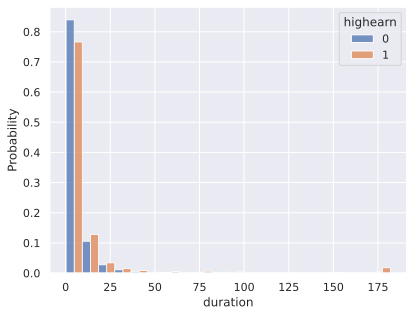

In [153]:
sns.histplot(df, x="duration", bins=20, hue="highearn", stat="probability", common_norm=False, multiple="dodge")
plt.show()

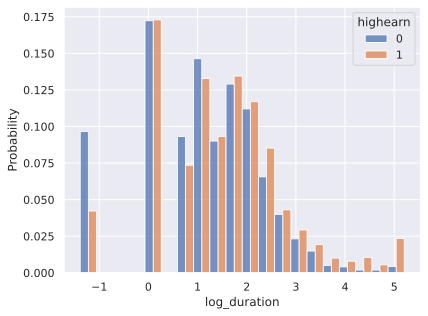

In [154]:
sns.histplot(df, x="log_duration", bins=20, hue="highearn", stat="probability", common_norm=False, multiple="dodge")  
plt.show()  

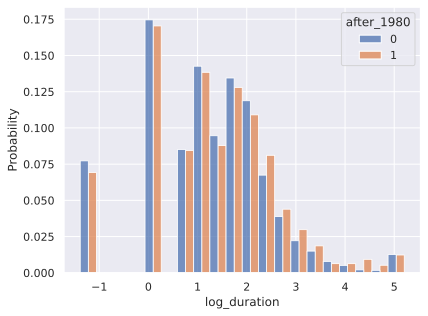

In [155]:
sns.histplot(df, x="log_duration", bins=20, hue="after_1980", stat="probability", common_norm=False, multiple="dodge")  
plt.show()  

<Axes: xlabel='highearn', ylabel='log_duration'>

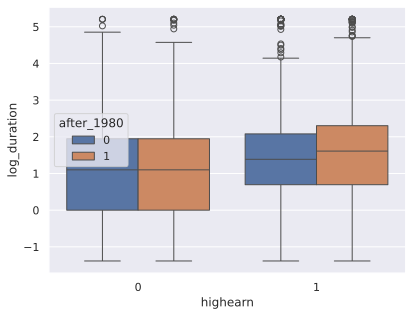

In [159]:
sns.boxplot(df, x="highearn", y="log_duration", hue="after_1980")

We could compute the DiD estimate by hand, or we could use linear regression in order to be able to also include other covariates.

The linear model we use is as follows:
$$
log(duration) = \beta_0 + \beta_1 highearn + \beta_2 after\; 1980 + \beta_3 (highearn \times after\;1980) + \beta X + \epsilon
$$

The various effects can be computed with the following table \
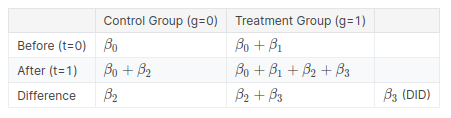

In [168]:
D = "highearn"
T = "after_1980"
X = ["male", "age", "married", "hosp", "C(indust)", "C(injtype)", "lprewage"]

result = smf.ols(f'log_duration ~ 1 + {D}*{T} + {" + ".join(X)}', data=df).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.5282,0.422,-3.620,0.000,-2.356,-0.700
C(indust)[T.2.0],0.1839,0.054,3.397,0.001,0.078,0.290
C(indust)[T.3.0],0.1635,0.038,4.319,0.000,0.089,0.238
C(injtype)[T.2],0.9355,0.144,6.508,0.000,0.654,1.217
C(injtype)[T.3],0.6355,0.085,7.437,0.000,0.468,0.803
C(injtype)[T.4],0.5545,0.093,5.973,0.000,0.373,0.737
C(injtype)[T.5],0.6412,0.085,7.505,0.000,0.474,0.809
C(injtype)[T.6],0.6150,0.086,7.126,0.000,0.446,0.784
C(injtype)[T.7],0.9913,0.191,5.203,0.000,0.618,1.365
C(injtype)[T.8],0.4341,0.119,3.650,0.000,0.201,0.667


In [169]:
beta_0 = result.params["Intercept"]
beta_1 = result.params[f"{D}"]
beta_2 = result.params[f"{T}"]
beta_3 = result.params[f"{D}:{T}"]

In [170]:
print(f"Control baseline: {beta_0}")
print(f"Treated baseline: {beta_0 + beta_1}")
print(f"Control after 1980: {beta_0 + beta_2}")
print(f"Treated after 1980:{beta_0 + beta_1 + beta_2 + beta_3}")

Control baseline: -1.5282018185033326
Treated baseline: -1.679982581737823
Control after 1980: -1.478662308972103
Treated after 1980:-1.4617217312726472
